# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   fortitude   1206 non-null   int64 
 1   dex         1206 non-null   int64 
 2   will        1206 non-null   int64 
 3   book        1206 non-null   object
 4   cha         1206 non-null   int64 
 5   perception  1206 non-null   int64 
 6   int         1206 non-null   int64 
 7   con         1206 non-null   int64 
 8   ac          1206 non-null   int64 
 9   wis         1206 non-null   int64 
 10  hp          1206 non-null   int64 
 11  level       1206 non-null   int64 
 12  reflex      1206 non-null   int64 
 13  focus       1206 non-null   int32 
 14  str         1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,fortitude,dex,will,book,cha,perception,int,con,ac,wis,hp,level,reflex,focus,str
0,22,2,17,Pathfinder Bestiary,1,20,1,5,29,2,215,10,19,1,7
1,21,0,16,Pathfinder Bestiary,1,16,-4,5,28,2,220,10,14,0,9
2,20,3,15,Pathfinder Bestiary,-2,17,-4,6,25,3,175,8,17,0,7
3,30,4,32,Pathfinder Bestiary,6,30,6,5,41,5,315,17,29,1,7
4,6,3,4,Pathfinder Bestiary,1,6,-1,1,16,1,20,1,10,1,-5


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


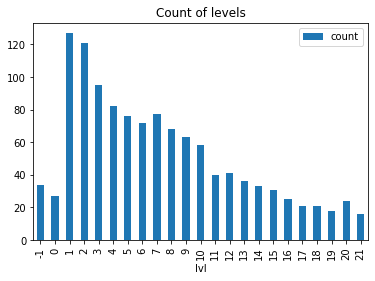

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, median_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = median_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.26
RMSE: 0.51
MAE: 0.22


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


In [17]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.29
RMSE: 0.54



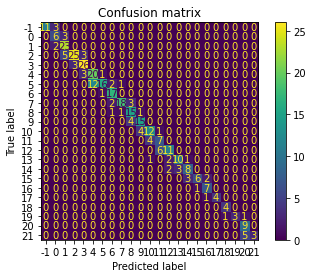

In [18]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [19]:
from training.results import assess_regression_model

In [20]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 18:25:13,814] A new study created in memory with name: no-name-83c40d9c-4d41-4b5a-96e5-59b90aaa3629
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.188997 + 0.0379828
[200]	cv_agg's l2: 0.18624 + 0.0364077
[300]	cv_agg's l2: 0.185811 + 0.0361291


feature_fraction, val_score: 0.185363:  14%|######4                                      | 1/7 [00:03<00:19,  3.24s/it]

Early stopping, best iteration is:
[261]	cv_agg's l2: 0.185363 + 0.0359535
[100]	cv_agg's l2: 0.169736 + 0.0346077
[200]	cv_agg's l2: 0.169631 + 0.031243


feature_fraction, val_score: 0.168568:  29%|############8                                | 2/7 [00:05<00:13,  2.64s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.168568 + 0.0321598
[100]	cv_agg's l2: 0.179584 + 0.0369947
[200]	cv_agg's l2: 0.177166 + 0.0353728


feature_fraction, val_score: 0.168568:  43%|###################2                         | 3/7 [00:08<00:10,  2.66s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.168568 + 0.0321598
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686


feature_fraction, val_score: 0.163159:  57%|#########################7                   | 4/7 [00:12<00:09,  3.14s/it]

[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.173079 + 0.0358194
[200]	cv_agg's l2: 0.171857 + 0.0345912
[300]	cv_agg's l2: 0.173226 + 0.0333421
[400]	cv_agg's l2: 0.174371 + 0.033232


feature_fraction, val_score: 0.163159:  71%|################################1            | 5/7 [00:16<00:06,  3.44s/it]

Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.170233 + 0.0352319
[200]	cv_agg's l2: 0.168071 + 0.0333769
[300]	cv_agg's l2: 0.168365 + 0.032633


feature_fraction, val_score: 0.163159:  86%|######################################5      | 6/7 [00:20<00:03,  3.83s/it]

[400]	cv_agg's l2: 0.168918 + 0.0324894
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.179246 + 0.0381093
[200]	cv_agg's l2: 0.177547 + 0.0361558
[300]	cv_agg's l2: 0.176499 + 0.0347554
[400]	cv_agg's l2: 0.177855 + 0.0348441


feature_fraction, val_score: 0.163159: 100%|#############################################| 7/7 [00:25<00:00,  3.70s/it]


Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208


num_leaves, val_score: 0.163159:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208


num_leaves, val_score: 0.163159:   5%|##5                                               | 1/20 [00:05<01:53,  5.99s/it]

[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686


num_leaves, val_score: 0.163159:  10%|#####                                             | 2/20 [00:10<01:29,  4.99s/it]

[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686


num_leaves, val_score: 0.163159:  15%|#######5                                          | 3/20 [00:14<01:17,  4.54s/it]

[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686


num_leaves, val_score: 0.163159:  20%|##########                                        | 4/20 [00:18<01:09,  4.32s/it]

[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686


num_leaves, val_score: 0.163159:  25%|############5                                     | 5/20 [00:22<01:02,  4.16s/it]

[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686


num_leaves, val_score: 0.163159:  30%|###############                                   | 6/20 [00:26<00:58,  4.19s/it]

[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686


num_leaves, val_score: 0.163159:  35%|#################5                                | 7/20 [00:30<00:53,  4.11s/it]

[400]	cv_agg's l2: 0.164425 + 0.0271078
Early stopping, best iteration is:
[315]	cv_agg's l2: 0.163159 + 0.0274208
[100]	cv_agg's l2: 0.181344 + 0.0281376
[200]	cv_agg's l2: 0.166917 + 0.022728
[300]	cv_agg's l2: 0.163396 + 0.0220486
[400]	cv_agg's l2: 0.161851 + 0.0223121
[500]	cv_agg's l2: 0.160844 + 0.0224433
[600]	cv_agg's l2: 0.160488 + 0.022788
[700]	cv_agg's l2: 0.160814 + 0.0230086


num_leaves, val_score: 0.160273:  40%|####################                              | 8/20 [00:32<00:43,  3.60s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.17838 + 0.0282175
[200]	cv_agg's l2: 0.167557 + 0.0245256
[300]	cv_agg's l2: 0.164305 + 0.0235133
[400]	cv_agg's l2: 0.162414 + 0.0229579
[500]	cv_agg's l2: 0.161839 + 0.0223358
[600]	cv_agg's l2: 0.161269 + 0.0221298
[700]	cv_agg's l2: 0.16102 + 0.0222377
Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681


num_leaves, val_score: 0.160273:  45%|######################5                           | 9/20 [00:35<00:37,  3.42s/it]

[100]	cv_agg's l2: 0.333137 + 0.0519651
[200]	cv_agg's l2: 0.296074 + 0.0460212
[300]	cv_agg's l2: 0.286067 + 0.0440806
[400]	cv_agg's l2: 0.278129 + 0.041888
[500]	cv_agg's l2: 0.27211 + 0.0404049
[600]	cv_agg's l2: 0.267125 + 0.039015


num_leaves, val_score: 0.160273:  50%|########################5                        | 10/20 [00:37<00:27,  2.73s/it]

[700]	cv_agg's l2: 0.262847 + 0.0381847
Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.198578 + 0.0335735
[200]	cv_agg's l2: 0.179277 + 0.0250484
[300]	cv_agg's l2: 0.172918 + 0.0220768
[400]	cv_agg's l2: 0.170045 + 0.0204779
[500]	cv_agg's l2: 0.167584 + 0.0189141
[600]	cv_agg's l2: 0.166345 + 0.0187636


num_leaves, val_score: 0.160273:  55%|##########################9                      | 11/20 [00:39<00:22,  2.50s/it]

[700]	cv_agg's l2: 0.166419 + 0.0183524
Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
[500]	cv_agg's l2: 0.165303 + 0.0271859
[600]	cv_agg's l2: 0.166395 + 0.0277135
[700]	cv_agg's l2: 0.167173 + 0.0280612


num_leaves, val_score: 0.160273:  60%|#############################4                   | 12/20 [00:45<00:30,  3.80s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
[500]	cv_agg's l2: 0.165303 + 0.0271859
[600]	cv_agg's l2: 0.166395 + 0.0277135
[700]	cv_agg's l2: 0.167173 + 0.0280612


num_leaves, val_score: 0.160273:  65%|###############################8                 | 13/20 [00:52<00:33,  4.77s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
[500]	cv_agg's l2: 0.165303 + 0.0271859
[600]	cv_agg's l2: 0.166395 + 0.0277135
[700]	cv_agg's l2: 0.167173 + 0.0280612


num_leaves, val_score: 0.160273:  70%|##################################3              | 14/20 [01:00<00:33,  5.60s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
[500]	cv_agg's l2: 0.165303 + 0.0271859
[600]	cv_agg's l2: 0.166395 + 0.0277135
[700]	cv_agg's l2: 0.167173 + 0.0280612


num_leaves, val_score: 0.160273:  75%|####################################7            | 15/20 [01:07<00:30,  6.07s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.165859 + 0.0300223
[200]	cv_agg's l2: 0.162108 + 0.0285231
[300]	cv_agg's l2: 0.163253 + 0.028195
[400]	cv_agg's l2: 0.163477 + 0.0284797
[500]	cv_agg's l2: 0.1643 + 0.0286937
[600]	cv_agg's l2: 0.165213 + 0.0285975
[700]	cv_agg's l2: 0.16602 + 0.0290104


num_leaves, val_score: 0.160273:  80%|#######################################2         | 16/20 [01:14<00:25,  6.38s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
[500]	cv_agg's l2: 0.165303 + 0.0271859
[600]	cv_agg's l2: 0.166395 + 0.0277135
[700]	cv_agg's l2: 0.167173 + 0.0280612


num_leaves, val_score: 0.160273:  85%|#########################################6       | 17/20 [01:21<00:19,  6.56s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
[500]	cv_agg's l2: 0.165303 + 0.0271859
[600]	cv_agg's l2: 0.166395 + 0.0277135
[700]	cv_agg's l2: 0.167173 + 0.0280612


num_leaves, val_score: 0.160273:  90%|############################################1    | 18/20 [01:28<00:13,  6.69s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.165344 + 0.0294019
[200]	cv_agg's l2: 0.161473 + 0.0281509
[300]	cv_agg's l2: 0.161483 + 0.0275743
[400]	cv_agg's l2: 0.162077 + 0.027694
[500]	cv_agg's l2: 0.163008 + 0.0278936
[600]	cv_agg's l2: 0.163876 + 0.0282838
[700]	cv_agg's l2: 0.164733 + 0.0287458


num_leaves, val_score: 0.160273:  95%|##############################################5  | 19/20 [01:35<00:06,  6.70s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.166762 + 0.0299547
[200]	cv_agg's l2: 0.164095 + 0.0284144
[300]	cv_agg's l2: 0.163224 + 0.027686
[400]	cv_agg's l2: 0.164425 + 0.0271078
[500]	cv_agg's l2: 0.165303 + 0.0271859
[600]	cv_agg's l2: 0.166395 + 0.0277135
[700]	cv_agg's l2: 0.167173 + 0.0280612


num_leaves, val_score: 0.160273: 100%|#################################################| 20/20 [01:42<00:00,  5.12s/it]


Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681


bagging, val_score: 0.160273:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.213111 + 0.0208018
[200]	cv_agg's l2: 0.197396 + 0.0206537
[300]	cv_agg's l2: 0.194597 + 0.0228569
[400]	cv_agg's l2: 0.192871 + 0.0213542
[500]	cv_agg's l2: 0.191521 + 0.0205598
[600]	cv_agg's l2: 0.189959 + 0.021348
[700]	cv_agg's l2: 0.189379 + 0.0189013


bagging, val_score: 0.160273:  10%|#####3                                               | 1/10 [00:02<00:25,  2.78s/it]

Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681
[100]	cv_agg's l2: 0.184646 + 0.0239098
[200]	cv_agg's l2: 0.171097 + 0.022347
[300]	cv_agg's l2: 0.166263 + 0.023193
[400]	cv_agg's l2: 0.164069 + 0.0217729
[500]	cv_agg's l2: 0.162861 + 0.0207969
[600]	cv_agg's l2: 0.162926 + 0.0209527


bagging, val_score: 0.160273:  10%|#####3                                               | 1/10 [00:05<00:25,  2.78s/it]

[700]	cv_agg's l2: 0.162009 + 0.0212724
Early stopping, best iteration is:
[654]	cv_agg's l2: 0.160273 + 0.0226681


bagging, val_score: 0.160273:  20%|##########6                                          | 2/10 [00:05<00:21,  2.74s/it]

[100]	cv_agg's l2: 0.183118 + 0.0215824
[200]	cv_agg's l2: 0.167883 + 0.0188994
[300]	cv_agg's l2: 0.163672 + 0.0201391
[400]	cv_agg's l2: 0.161353 + 0.0194885
[500]	cv_agg's l2: 0.160276 + 0.0195441
[600]	cv_agg's l2: 0.159869 + 0.019737
[700]	cv_agg's l2: 0.158653 + 0.0191753


bagging, val_score: 0.158315:  30%|###############9                                     | 3/10 [00:08<00:19,  2.84s/it]

[800]	cv_agg's l2: 0.158921 + 0.0205705
Early stopping, best iteration is:
[721]	cv_agg's l2: 0.158315 + 0.0193121
[100]	cv_agg's l2: 0.179562 + 0.0256391
[200]	cv_agg's l2: 0.165153 + 0.0222185
[300]	cv_agg's l2: 0.160481 + 0.0200212
[400]	cv_agg's l2: 0.158955 + 0.0198892
[500]	cv_agg's l2: 0.158277 + 0.0204719
[600]	cv_agg's l2: 0.157239 + 0.020179


bagging, val_score: 0.157106:  40%|#####################2                               | 4/10 [00:11<00:16,  2.75s/it]

[700]	cv_agg's l2: 0.157791 + 0.0196748
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.181344 + 0.0281376
[200]	cv_agg's l2: 0.166917 + 0.022728
[300]	cv_agg's l2: 0.163396 + 0.0220486
[400]	cv_agg's l2: 0.161851 + 0.0223121
[500]	cv_agg's l2: 0.160844 + 0.0224433
[600]	cv_agg's l2: 0.160488 + 0.022788


bagging, val_score: 0.157106:  50%|##########################5                          | 5/10 [00:13<00:13,  2.65s/it]

[700]	cv_agg's l2: 0.160814 + 0.0230086
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.18838 + 0.029523
[200]	cv_agg's l2: 0.173471 + 0.025638
[300]	cv_agg's l2: 0.168872 + 0.0246411
[400]	cv_agg's l2: 0.165967 + 0.0237271
[500]	cv_agg's l2: 0.163593 + 0.0225345
[600]	cv_agg's l2: 0.162107 + 0.0224741


bagging, val_score: 0.157106:  60%|###############################8                     | 6/10 [00:16<00:10,  2.59s/it]

[700]	cv_agg's l2: 0.161977 + 0.0222164
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.182359 + 0.0246226
[200]	cv_agg's l2: 0.168014 + 0.0192559
[300]	cv_agg's l2: 0.163268 + 0.0172187
[400]	cv_agg's l2: 0.160623 + 0.0174596
[500]	cv_agg's l2: 0.158374 + 0.0164039
[600]	cv_agg's l2: 0.157908 + 0.0161059


bagging, val_score: 0.157106:  60%|###############################8                     | 6/10 [00:18<00:10,  2.59s/it]

[700]	cv_agg's l2: 0.157723 + 0.0163068
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519


bagging, val_score: 0.157106:  70%|#####################################                | 7/10 [00:18<00:08,  2.71s/it]

[100]	cv_agg's l2: 0.18456 + 0.0281905
[200]	cv_agg's l2: 0.170908 + 0.0197904
[300]	cv_agg's l2: 0.165862 + 0.0193001
[400]	cv_agg's l2: 0.162444 + 0.0174708
[500]	cv_agg's l2: 0.160229 + 0.0160824
[600]	cv_agg's l2: 0.158948 + 0.0168096


bagging, val_score: 0.157106:  80%|##########################################4          | 8/10 [00:21<00:05,  2.70s/it]

[700]	cv_agg's l2: 0.158471 + 0.0152395
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.188255 + 0.0295105
[200]	cv_agg's l2: 0.170468 + 0.02436
[300]	cv_agg's l2: 0.165 + 0.0227245
[400]	cv_agg's l2: 0.162858 + 0.019446
[500]	cv_agg's l2: 0.161558 + 0.018869
[600]	cv_agg's l2: 0.160731 + 0.0181009


bagging, val_score: 0.157106:  90%|###############################################7     | 9/10 [00:24<00:02,  2.71s/it]

[700]	cv_agg's l2: 0.160407 + 0.017404
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.189788 + 0.0300498
[200]	cv_agg's l2: 0.175606 + 0.0227476
[300]	cv_agg's l2: 0.170041 + 0.0215528
[400]	cv_agg's l2: 0.167054 + 0.0188323
[500]	cv_agg's l2: 0.165222 + 0.0175979
[600]	cv_agg's l2: 0.163627 + 0.0177148


bagging, val_score: 0.157106: 100%|####################################################| 10/10 [00:26<00:00,  2.70s/it]


[700]	cv_agg's l2: 0.163687 + 0.0163168
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519


feature_fraction_stage2, val_score: 0.157106:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.181559 + 0.0231789
[200]	cv_agg's l2: 0.166164 + 0.0196848
[300]	cv_agg's l2: 0.161225 + 0.0179789
[400]	cv_agg's l2: 0.159838 + 0.0187875
[500]	cv_agg's l2: 0.158674 + 0.0176833
[600]	cv_agg's l2: 0.158044 + 0.0176953


feature_fraction_stage2, val_score: 0.157106:  17%|######3                               | 1/6 [00:02<00:13,  2.66s/it]

[700]	cv_agg's l2: 0.157613 + 0.0183092
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.179562 + 0.0256391
[200]	cv_agg's l2: 0.165153 + 0.0222185
[300]	cv_agg's l2: 0.160481 + 0.0200212
[400]	cv_agg's l2: 0.158955 + 0.0198892
[500]	cv_agg's l2: 0.158277 + 0.0204719
[600]	cv_agg's l2: 0.157239 + 0.020179


feature_fraction_stage2, val_score: 0.157106:  33%|############6                         | 2/6 [00:05<00:10,  2.69s/it]

[700]	cv_agg's l2: 0.157791 + 0.0196748
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.177745 + 0.0224187
[200]	cv_agg's l2: 0.166818 + 0.0187611
[300]	cv_agg's l2: 0.162445 + 0.016904
[400]	cv_agg's l2: 0.161546 + 0.0165058
[500]	cv_agg's l2: 0.160615 + 0.0161585
[600]	cv_agg's l2: 0.159285 + 0.0155429


feature_fraction_stage2, val_score: 0.157106:  50%|###################                   | 3/6 [00:07<00:07,  2.63s/it]

[700]	cv_agg's l2: 0.159467 + 0.0161915
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.179562 + 0.0256391
[200]	cv_agg's l2: 0.165153 + 0.0222185
[300]	cv_agg's l2: 0.160481 + 0.0200212
[400]	cv_agg's l2: 0.158955 + 0.0198892
[500]	cv_agg's l2: 0.158277 + 0.0204719
[600]	cv_agg's l2: 0.157239 + 0.020179


feature_fraction_stage2, val_score: 0.157106:  67%|#########################3            | 4/6 [00:10<00:05,  2.60s/it]

[700]	cv_agg's l2: 0.157791 + 0.0196748
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.157106 + 0.0200519
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


feature_fraction_stage2, val_score: 0.156413:  83%|###############################6      | 5/6 [00:13<00:02,  2.72s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


feature_fraction_stage2, val_score: 0.156413: 100%|######################################| 6/6 [00:16<00:00,  2.71s/it]


[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686


regularization_factors, val_score: 0.156413:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:   5%|#9                                    | 1/20 [00:02<00:56,  2.97s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  10%|###8                                  | 2/20 [00:05<00:52,  2.94s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  15%|#####7                                | 3/20 [00:08<00:50,  2.96s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  20%|#######6                              | 4/20 [00:12<00:50,  3.17s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  25%|#########5                            | 5/20 [00:14<00:41,  2.77s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  30%|###########4                          | 6/20 [00:16<00:35,  2.56s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  35%|#############3                        | 7/20 [00:18<00:31,  2.41s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  40%|###############2                      | 8/20 [00:21<00:31,  2.59s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  45%|#################1                    | 9/20 [00:24<00:30,  2.74s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156413:  50%|##################5                  | 10/20 [00:27<00:27,  2.78s/it]

[800]	cv_agg's l2: 0.156502 + 0.0194905
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157643 + 0.0186758
[700]	cv_agg's l2: 0.156834 + 0.0185158


regularization_factors, val_score: 0.156413:  55%|####################3                | 11/20 [00:30<00:25,  2.82s/it]

[800]	cv_agg's l2: 0.156796 + 0.0191585
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157643 + 0.0186758
[700]	cv_agg's l2: 0.156834 + 0.0185158


regularization_factors, val_score: 0.156413:  60%|######################2              | 12/20 [00:33<00:22,  2.87s/it]

[800]	cv_agg's l2: 0.156796 + 0.0191585
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157643 + 0.0186758
[700]	cv_agg's l2: 0.156834 + 0.0185158


regularization_factors, val_score: 0.156413:  65%|########################             | 13/20 [00:36<00:20,  2.90s/it]

[800]	cv_agg's l2: 0.156796 + 0.0191585
Early stopping, best iteration is:
[705]	cv_agg's l2: 0.156413 + 0.0188686
[100]	cv_agg's l2: 0.177784 + 0.023587
[200]	cv_agg's l2: 0.166735 + 0.0234426
[300]	cv_agg's l2: 0.161408 + 0.0217012
[400]	cv_agg's l2: 0.159246 + 0.020717
[500]	cv_agg's l2: 0.157481 + 0.0197752
[600]	cv_agg's l2: 0.156935 + 0.0195868
[700]	cv_agg's l2: 0.156336 + 0.0192232


regularization_factors, val_score: 0.156212:  70%|#########################9           | 14/20 [00:39<00:17,  2.90s/it]

Early stopping, best iteration is:
[680]	cv_agg's l2: 0.156212 + 0.0193264
[100]	cv_agg's l2: 0.177899 + 0.0229447
[200]	cv_agg's l2: 0.167278 + 0.0218583
[300]	cv_agg's l2: 0.162592 + 0.0195621
[400]	cv_agg's l2: 0.160419 + 0.018759
[500]	cv_agg's l2: 0.159669 + 0.0182736
[600]	cv_agg's l2: 0.157352 + 0.0181535
[700]	cv_agg's l2: 0.157074 + 0.0188069


regularization_factors, val_score: 0.156212:  75%|###########################7         | 15/20 [00:42<00:14,  2.87s/it]

Early stopping, best iteration is:
[680]	cv_agg's l2: 0.156212 + 0.0193264
[100]	cv_agg's l2: 0.17829 + 0.0229029
[200]	cv_agg's l2: 0.167484 + 0.0224436
[300]	cv_agg's l2: 0.162271 + 0.0205765
[400]	cv_agg's l2: 0.159914 + 0.0198866
[500]	cv_agg's l2: 0.158124 + 0.0190161
[600]	cv_agg's l2: 0.157523 + 0.0188213
[700]	cv_agg's l2: 0.156602 + 0.018782


regularization_factors, val_score: 0.156212:  80%|#############################6       | 16/20 [00:44<00:11,  2.84s/it]

Early stopping, best iteration is:
[680]	cv_agg's l2: 0.156212 + 0.0193264
[100]	cv_agg's l2: 0.178291 + 0.0229035
[200]	cv_agg's l2: 0.167613 + 0.0223532
[300]	cv_agg's l2: 0.162237 + 0.0203475
[400]	cv_agg's l2: 0.159629 + 0.0198556
[500]	cv_agg's l2: 0.158124 + 0.0188643
[600]	cv_agg's l2: 0.157326 + 0.0185461
[700]	cv_agg's l2: 0.15758 + 0.0186005


regularization_factors, val_score: 0.156212:  85%|###############################4     | 17/20 [00:48<00:08,  2.90s/it]

Early stopping, best iteration is:
[680]	cv_agg's l2: 0.156212 + 0.0193264
[100]	cv_agg's l2: 0.177784 + 0.0235874
[200]	cv_agg's l2: 0.166736 + 0.023443
[300]	cv_agg's l2: 0.161558 + 0.0215005
[400]	cv_agg's l2: 0.159066 + 0.0209542
[500]	cv_agg's l2: 0.157313 + 0.0199922
[600]	cv_agg's l2: 0.156538 + 0.0201011
[700]	cv_agg's l2: 0.155588 + 0.0201779
[800]	cv_agg's l2: 0.155481 + 0.0207619
[900]	cv_agg's l2: 0.155218 + 0.0205156


regularization_factors, val_score: 0.155094:  90%|#################################3   | 18/20 [00:51<00:06,  3.19s/it]

[1000]	cv_agg's l2: 0.155587 + 0.0211352
Early stopping, best iteration is:
[924]	cv_agg's l2: 0.155094 + 0.0208569
[100]	cv_agg's l2: 0.177784 + 0.0235874
[200]	cv_agg's l2: 0.166736 + 0.0234429
[300]	cv_agg's l2: 0.161558 + 0.0215005
[400]	cv_agg's l2: 0.159066 + 0.0209542
[500]	cv_agg's l2: 0.157313 + 0.0199922
[600]	cv_agg's l2: 0.156538 + 0.0201011
[700]	cv_agg's l2: 0.155588 + 0.0201779
[800]	cv_agg's l2: 0.155481 + 0.0207618
[900]	cv_agg's l2: 0.155218 + 0.0205156


regularization_factors, val_score: 0.155094:  95%|###################################1 | 19/20 [00:55<00:03,  3.36s/it]

[1000]	cv_agg's l2: 0.155587 + 0.0211352
Early stopping, best iteration is:
[924]	cv_agg's l2: 0.155094 + 0.0208569
[100]	cv_agg's l2: 0.177783 + 0.0235865
[200]	cv_agg's l2: 0.167127 + 0.0238986
[300]	cv_agg's l2: 0.16155 + 0.0219005
[400]	cv_agg's l2: 0.159963 + 0.0214572
[500]	cv_agg's l2: 0.15863 + 0.0212529
[600]	cv_agg's l2: 0.157383 + 0.0201034
[700]	cv_agg's l2: 0.157533 + 0.0206899
[800]	cv_agg's l2: 0.157221 + 0.0208376
[900]	cv_agg's l2: 0.15697 + 0.0208883


regularization_factors, val_score: 0.155094: 100%|#####################################| 20/20 [00:59<00:00,  2.96s/it]


[1000]	cv_agg's l2: 0.156887 + 0.0212801
Early stopping, best iteration is:
[924]	cv_agg's l2: 0.155094 + 0.0208569


min_data_in_leaf, val_score: 0.155094:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.25239 + 0.0434205
[200]	cv_agg's l2: 0.236372 + 0.0471365
[300]	cv_agg's l2: 0.229997 + 0.049752
[400]	cv_agg's l2: 0.22841 + 0.0506863
[500]	cv_agg's l2: 0.228088 + 0.0527591
[600]	cv_agg's l2: 0.226982 + 0.0528108
[700]	cv_agg's l2: 0.227949 + 0.0537954
[800]	cv_agg's l2: 0.226968 + 0.0532523
[900]	cv_agg's l2: 0.227829 + 0.0542152


min_data_in_leaf, val_score: 0.155094:  20%|#########                                    | 1/5 [00:03<00:15,  3.87s/it]

[1000]	cv_agg's l2: 0.229006 + 0.0544839
Early stopping, best iteration is:
[924]	cv_agg's l2: 0.155094 + 0.0208569
[100]	cv_agg's l2: 0.189713 + 0.0281692
[200]	cv_agg's l2: 0.176709 + 0.025592
[300]	cv_agg's l2: 0.17122 + 0.0236283
[400]	cv_agg's l2: 0.168741 + 0.0225768
[500]	cv_agg's l2: 0.167133 + 0.0224874
[600]	cv_agg's l2: 0.165505 + 0.0222824
[700]	cv_agg's l2: 0.16522 + 0.0220574
[800]	cv_agg's l2: 0.164843 + 0.0222866
[900]	cv_agg's l2: 0.165119 + 0.022293


min_data_in_leaf, val_score: 0.155094:  40%|##################                           | 2/5 [00:07<00:11,  3.77s/it]

[1000]	cv_agg's l2: 0.164889 + 0.0214957
Early stopping, best iteration is:
[924]	cv_agg's l2: 0.155094 + 0.0208569
[100]	cv_agg's l2: 0.78723 + 0.153854
[200]	cv_agg's l2: 0.756912 + 0.151915
[300]	cv_agg's l2: 0.739081 + 0.14809
[400]	cv_agg's l2: 0.727293 + 0.145236
[500]	cv_agg's l2: 0.720918 + 0.14529
[600]	cv_agg's l2: 0.717712 + 0.148394
[700]	cv_agg's l2: 0.715285 + 0.149542
[800]	cv_agg's l2: 0.71235 + 0.151575
[900]	cv_agg's l2: 0.711449 + 0.151394


min_data_in_leaf, val_score: 0.155094:  60%|###########################                  | 3/5 [00:10<00:06,  3.43s/it]

[1000]	cv_agg's l2: 0.712418 + 0.156021
Early stopping, best iteration is:
[924]	cv_agg's l2: 0.155094 + 0.0208569
[100]	cv_agg's l2: 0.15954 + 0.0209141
[200]	cv_agg's l2: 0.148146 + 0.0188817
[300]	cv_agg's l2: 0.144819 + 0.018666
[400]	cv_agg's l2: 0.142474 + 0.0183471
[500]	cv_agg's l2: 0.141314 + 0.0179601
[600]	cv_agg's l2: 0.139804 + 0.0172161


min_data_in_leaf, val_score: 0.139360:  80%|####################################         | 4/5 [00:13<00:03,  3.10s/it]

[700]	cv_agg's l2: 0.139578 + 0.0174752
Early stopping, best iteration is:
[611]	cv_agg's l2: 0.13936 + 0.0171831
[100]	cv_agg's l2: 0.160526 + 0.0226314
[200]	cv_agg's l2: 0.148873 + 0.0207171
[300]	cv_agg's l2: 0.144423 + 0.0198085
[400]	cv_agg's l2: 0.142002 + 0.0198705
[500]	cv_agg's l2: 0.140544 + 0.0199246
[600]	cv_agg's l2: 0.139251 + 0.0197122
[700]	cv_agg's l2: 0.138804 + 0.0193382


min_data_in_leaf, val_score: 0.138379: 100%|#############################################| 5/5 [00:16<00:00,  3.26s/it]

[800]	cv_agg's l2: 0.138729 + 0.0192434
Early stopping, best iteration is:
[743]	cv_agg's l2: 0.138379 + 0.019215


In [21]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1383790330807521
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.595740182421433e-08
    lambda_l2: 0.001176658520073412
    num_leaves: 7
    feature_fraction: 0.484
    bagging_fraction: 0.9782955069666581
    bagging_freq: 1
    min_child_samples: 5


In [22]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [23]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.46
MSE test: 0.21
MAE test: 0.33



In [24]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [25]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.21
RMSE: 0.46

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.26
RMSE: 0.51

Round type: 0.45
MSE: 0.24
RMSE: 0.49



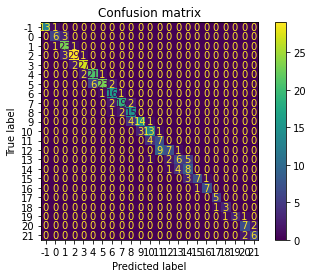

In [26]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.148111	valid_0's l1: 0.267273


In [28]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [29]:
from sklearn.metrics import mean_squared_error, median_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = median_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.15
RMSE: 0.38
MAE: 0.16


In [30]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

In [31]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.15
RMSE: 0.38

Round type: round
MSE: 0.15
RMSE: 0.39

Round type: 0.33
MSE: 0.21
RMSE: 0.45

Round type: 0.45
MSE: 0.17
RMSE: 0.41



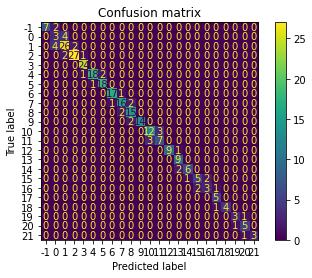

In [32]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [33]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 18:29:34,693] A new study created in memory with name: no-name-9d9ec0da-bff5-40f5-b4e3-c45a29a21cdc
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.19116 + 0.0445526
[200]	cv_agg's l2: 0.190441 + 0.0434714


feature_fraction, val_score: 0.189858:  14%|######4                                      | 1/7 [00:02<00:16,  2.70s/it]

Early stopping, best iteration is:
[172]	cv_agg's l2: 0.189858 + 0.0438854
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


feature_fraction, val_score: 0.159662:  29%|############8                                | 2/7 [00:04<00:12,  2.44s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.182753 + 0.0525577
[200]	cv_agg's l2: 0.181365 + 0.0490198


feature_fraction, val_score: 0.159662:  43%|###################2                         | 3/7 [00:07<00:09,  2.41s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.175194 + 0.0453135
[200]	cv_agg's l2: 0.174451 + 0.0431343


feature_fraction, val_score: 0.159662:  57%|#########################7                   | 4/7 [00:09<00:07,  2.41s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.175186 + 0.0452341
[200]	cv_agg's l2: 0.173088 + 0.042025


feature_fraction, val_score: 0.159662:  71%|################################1            | 5/7 [00:12<00:04,  2.43s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.18602 + 0.0516673
[200]	cv_agg's l2: 0.185205 + 0.0479119


feature_fraction, val_score: 0.159662:  86%|######################################5      | 6/7 [00:14<00:02,  2.41s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.194224 + 0.0441197
[200]	cv_agg's l2: 0.190781 + 0.0408776


feature_fraction, val_score: 0.159662: 100%|#############################################| 7/7 [00:17<00:00,  2.44s/it]


Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686


num_leaves, val_score: 0.159662:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:   5%|##5                                               | 1/20 [00:02<00:43,  2.28s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  10%|#####                                             | 2/20 [00:04<00:41,  2.28s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  15%|#######5                                          | 3/20 [00:06<00:38,  2.29s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  20%|##########                                        | 4/20 [00:09<00:38,  2.39s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.169927 + 0.0353466


num_leaves, val_score: 0.159662:  25%|############5                                     | 5/20 [00:10<00:28,  1.90s/it]

[200]	cv_agg's l2: 0.163106 + 0.0311497
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  30%|###############                                   | 6/20 [00:12<00:28,  2.04s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  35%|#################5                                | 7/20 [00:15<00:27,  2.14s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  40%|####################                              | 8/20 [00:17<00:26,  2.20s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  45%|######################5                           | 9/20 [00:19<00:24,  2.21s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.356459 + 0.0992065


num_leaves, val_score: 0.159662:  50%|########################5                        | 10/20 [00:20<00:16,  1.65s/it]

[200]	cv_agg's l2: 0.310873 + 0.0864138
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  55%|##########################9                      | 11/20 [00:22<00:16,  1.85s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  60%|#############################4                   | 12/20 [00:24<00:15,  1.94s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  65%|###############################8                 | 13/20 [00:26<00:13,  1.99s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  70%|##################################3              | 14/20 [00:29<00:13,  2.18s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  75%|####################################7            | 15/20 [00:32<00:12,  2.45s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686


num_leaves, val_score: 0.159662:  80%|#######################################2         | 16/20 [00:33<00:08,  2.16s/it]

[100]	cv_agg's l2: 0.160384 + 0.0341364
[200]	cv_agg's l2: 0.160474 + 0.0326698


num_leaves, val_score: 0.159662:  85%|#########################################6       | 17/20 [00:35<00:05,  1.90s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.163179 + 0.0328794


num_leaves, val_score: 0.159662:  85%|#########################################6       | 17/20 [00:36<00:05,  1.90s/it]

[200]	cv_agg's l2: 0.163008 + 0.0319208
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686


num_leaves, val_score: 0.159662:  90%|############################################1    | 18/20 [00:36<00:03,  1.63s/it]

[100]	cv_agg's l2: 0.160384 + 0.0341364


num_leaves, val_score: 0.159662:  90%|############################################1    | 18/20 [00:37<00:03,  1.63s/it]

[200]	cv_agg's l2: 0.160474 + 0.0326698
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686


num_leaves, val_score: 0.159662:  95%|##############################################5  | 19/20 [00:37<00:01,  1.54s/it]

[100]	cv_agg's l2: 0.160384 + 0.0341364


num_leaves, val_score: 0.159662: 100%|#################################################| 20/20 [00:38<00:00,  1.39s/it]

[200]	cv_agg's l2: 0.160474 + 0.0326698
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686


[I 2023-10-28 18:30:30,203] Trial 26 finished with value: 0.15966227377918035 and parameters: {'num_leaves': 66}. Best is trial 7 with value: 0.15966227377918035.
bagging, val_score: 0.159662:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.174616 + 0.0391372


bagging, val_score: 0.159662:  10%|#####3                                               | 1/10 [00:00<00:08,  1.07it/s]

[200]	cv_agg's l2: 0.172279 + 0.0326971
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.223883 + 0.0341429


bagging, val_score: 0.159662:  20%|##########6                                          | 2/10 [00:01<00:06,  1.19it/s]

[200]	cv_agg's l2: 0.210477 + 0.0258981
Early stopping, best iteration is:
[142]	cv_agg's l2: 0.159662 + 0.0328686
[100]	cv_agg's l2: 0.159831 + 0.0319711


bagging, val_score: 0.158520:  30%|###############9                                     | 3/10 [00:02<00:06,  1.07it/s]

[200]	cv_agg's l2: 0.15932 + 0.0314749
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.160303 + 0.0320984


bagging, val_score: 0.158520:  40%|#####################2                               | 4/10 [00:03<00:05,  1.06it/s]

[200]	cv_agg's l2: 0.160276 + 0.0315262
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.161472 + 0.0269916


bagging, val_score: 0.158520:  50%|##########################5                          | 5/10 [00:04<00:04,  1.08it/s]

[200]	cv_agg's l2: 0.162224 + 0.0248637
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.173423 + 0.0352909


bagging, val_score: 0.158520:  60%|###############################8                     | 6/10 [00:05<00:03,  1.07it/s]

[200]	cv_agg's l2: 0.169223 + 0.0320525
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.181164 + 0.0370045


bagging, val_score: 0.158520:  70%|#####################################                | 7/10 [00:06<00:02,  1.11it/s]

[200]	cv_agg's l2: 0.173839 + 0.0343902
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.184594 + 0.0351916


bagging, val_score: 0.158520:  80%|##########################################4          | 8/10 [00:07<00:01,  1.19it/s]

[200]	cv_agg's l2: 0.181186 + 0.0313208
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.166833 + 0.0355635


bagging, val_score: 0.158520:  90%|###############################################7     | 9/10 [00:08<00:00,  1.14it/s]

[200]	cv_agg's l2: 0.164486 + 0.0333827
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.180135 + 0.038076


bagging, val_score: 0.158520: 100%|####################################################| 10/10 [00:08<00:00,  1.14it/s]


[200]	cv_agg's l2: 0.176235 + 0.0322697
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795


feature_fraction_stage2, val_score: 0.158520:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.159831 + 0.0319711


feature_fraction_stage2, val_score: 0.158520:  33%|############6                         | 1/3 [00:00<00:01,  1.02it/s]

[200]	cv_agg's l2: 0.15932 + 0.0314749
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.169568 + 0.0340273
[200]	cv_agg's l2: 0.169134 + 0.0317278


feature_fraction_stage2, val_score: 0.158520:  67%|#########################3            | 2/3 [00:02<00:01,  1.54s/it]

Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795
[100]	cv_agg's l2: 0.169568 + 0.0340273


feature_fraction_stage2, val_score: 0.158520: 100%|######################################| 3/3 [00:04<00:00,  1.43s/it]


[200]	cv_agg's l2: 0.169134 + 0.0317278
Early stopping, best iteration is:
[123]	cv_agg's l2: 0.15852 + 0.0319795


regularization_factors, val_score: 0.158520:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.159677 + 0.0316918


regularization_factors, val_score: 0.158328:   5%|#9                                    | 1/20 [00:01<00:25,  1.34s/it]

[200]	cv_agg's l2: 0.159121 + 0.0317577
Early stopping, best iteration is:
[132]	cv_agg's l2: 0.158328 + 0.032198
[100]	cv_agg's l2: 0.160126 + 0.0313491


regularization_factors, val_score: 0.158328:  10%|###8                                  | 2/20 [00:02<00:25,  1.39s/it]

[200]	cv_agg's l2: 0.159192 + 0.0317108
Early stopping, best iteration is:
[132]	cv_agg's l2: 0.158328 + 0.032198
[100]	cv_agg's l2: 0.159677 + 0.0316918


regularization_factors, val_score: 0.158328:  10%|###8                                  | 2/20 [00:04<00:25,  1.39s/it]

[200]	cv_agg's l2: 0.159089 + 0.0317938
Early stopping, best iteration is:
[132]	cv_agg's l2: 0.158328 + 0.0321979


regularization_factors, val_score: 0.158328:  15%|#####7                                | 3/20 [00:04<00:24,  1.43s/it]

[100]	cv_agg's l2: 0.159169 + 0.0317426
[200]	cv_agg's l2: 0.15816 + 0.0317433


regularization_factors, val_score: 0.157423:  20%|#######6                              | 4/20 [00:05<00:23,  1.46s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182
[100]	cv_agg's l2: 0.159677 + 0.0316918
[200]	cv_agg's l2: 0.159051 + 0.0318197


regularization_factors, val_score: 0.157423:  25%|#########5                            | 5/20 [00:06<00:20,  1.37s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182
[100]	cv_agg's l2: 0.159677 + 0.0316919


regularization_factors, val_score: 0.157423:  25%|#########5                            | 5/20 [00:08<00:20,  1.37s/it]

[200]	cv_agg's l2: 0.159121 + 0.0317577
Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182


regularization_factors, val_score: 0.157423:  30%|###########4                          | 6/20 [00:08<00:18,  1.30s/it]

[100]	cv_agg's l2: 0.159421 + 0.0316555
[200]	cv_agg's l2: 0.15921 + 0.0311034


regularization_factors, val_score: 0.157423:  35%|#############3                        | 7/20 [00:09<00:17,  1.37s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182
[100]	cv_agg's l2: 0.165023 + 0.0357405


regularization_factors, val_score: 0.157423:  35%|#############3                        | 7/20 [00:10<00:17,  1.37s/it]

[200]	cv_agg's l2: 0.162811 + 0.0352477
Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182


regularization_factors, val_score: 0.157423:  40%|###############2                      | 8/20 [00:10<00:16,  1.34s/it]

[100]	cv_agg's l2: 0.159707 + 0.0313992
[200]	cv_agg's l2: 0.159015 + 0.0311086


regularization_factors, val_score: 0.157423:  45%|#################1                    | 9/20 [00:12<00:14,  1.28s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182
[100]	cv_agg's l2: 0.160174 + 0.0319277
[200]	cv_agg's l2: 0.160011 + 0.0308887


regularization_factors, val_score: 0.157423:  50%|##################5                  | 10/20 [00:13<00:13,  1.33s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182
[100]	cv_agg's l2: 0.159831 + 0.0319711


regularization_factors, val_score: 0.157423:  50%|##################5                  | 10/20 [00:14<00:13,  1.33s/it]

[200]	cv_agg's l2: 0.15932 + 0.0314749
Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182


regularization_factors, val_score: 0.157423:  55%|####################3                | 11/20 [00:14<00:11,  1.26s/it]

[100]	cv_agg's l2: 0.159842 + 0.0322759
[200]	cv_agg's l2: 0.159233 + 0.0327719


regularization_factors, val_score: 0.157423:  60%|######################2              | 12/20 [00:16<00:10,  1.31s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.157423 + 0.0316182
[100]	cv_agg's l2: 0.158444 + 0.0303116


regularization_factors, val_score: 0.157269:  60%|######################2              | 12/20 [00:17<00:10,  1.31s/it]

[200]	cv_agg's l2: 0.159032 + 0.0310907
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303


regularization_factors, val_score: 0.157269:  65%|########################             | 13/20 [00:17<00:08,  1.25s/it]

[100]	cv_agg's l2: 0.159332 + 0.0337443


regularization_factors, val_score: 0.157269:  70%|#########################9           | 14/20 [00:18<00:08,  1.35s/it]

[200]	cv_agg's l2: 0.159296 + 0.0327877
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303
[100]	cv_agg's l2: 0.160776 + 0.0311045


regularization_factors, val_score: 0.157269:  75%|###########################7         | 15/20 [00:20<00:06,  1.36s/it]

[200]	cv_agg's l2: 0.159841 + 0.0304059
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303
[100]	cv_agg's l2: 0.159249 + 0.0313072


regularization_factors, val_score: 0.157269:  80%|#############################6       | 16/20 [00:21<00:05,  1.35s/it]

[200]	cv_agg's l2: 0.158933 + 0.03087
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303
[100]	cv_agg's l2: 0.159249 + 0.0313072


regularization_factors, val_score: 0.157269:  85%|###############################4     | 17/20 [00:22<00:03,  1.28s/it]

[200]	cv_agg's l2: 0.158933 + 0.03087
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303
[100]	cv_agg's l2: 0.159038 + 0.0314519


regularization_factors, val_score: 0.157269:  90%|#################################3   | 18/20 [00:23<00:02,  1.24s/it]

[200]	cv_agg's l2: 0.1582 + 0.0313524
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303
[100]	cv_agg's l2: 0.159249 + 0.0313072


regularization_factors, val_score: 0.157269:  95%|###################################1 | 19/20 [00:24<00:01,  1.17s/it]

[200]	cv_agg's l2: 0.158933 + 0.03087
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303
[100]	cv_agg's l2: 0.159512 + 0.0309177


regularization_factors, val_score: 0.157269: 100%|#####################################| 20/20 [00:25<00:00,  1.29s/it]


[200]	cv_agg's l2: 0.159921 + 0.0310975
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.157269 + 0.0303


min_data_in_leaf, val_score: 0.157269:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.152431 + 0.0400435
[200]	cv_agg's l2: 0.150778 + 0.0377373


min_data_in_leaf, val_score: 0.150335:  20%|#########                                    | 1/5 [00:01<00:07,  1.77s/it]

[300]	cv_agg's l2: 0.150971 + 0.037575
Early stopping, best iteration is:
[214]	cv_agg's l2: 0.150335 + 0.0377947
[100]	cv_agg's l2: 0.676298 + 0.0657864
[200]	cv_agg's l2: 0.638838 + 0.059075


min_data_in_leaf, val_score: 0.150335:  40%|##################                           | 2/5 [00:02<00:03,  1.08s/it]

[300]	cv_agg's l2: 0.622496 + 0.0635288
Early stopping, best iteration is:
[214]	cv_agg's l2: 0.150335 + 0.0377947
[100]	cv_agg's l2: 0.152219 + 0.0391967
[200]	cv_agg's l2: 0.15163 + 0.0373377


min_data_in_leaf, val_score: 0.150335:  60%|###########################                  | 3/5 [00:04<00:02,  1.35s/it]

[300]	cv_agg's l2: 0.151449 + 0.0371511
Early stopping, best iteration is:
[214]	cv_agg's l2: 0.150335 + 0.0377947
[100]	cv_agg's l2: 0.23312 + 0.0438066
[200]	cv_agg's l2: 0.224764 + 0.0376983


min_data_in_leaf, val_score: 0.150335:  80%|####################################         | 4/5 [00:04<00:01,  1.13s/it]

[300]	cv_agg's l2: 0.220692 + 0.0360192
Early stopping, best iteration is:
[214]	cv_agg's l2: 0.150335 + 0.0377947
[100]	cv_agg's l2: 0.170633 + 0.0339733
[200]	cv_agg's l2: 0.166672 + 0.0320557


min_data_in_leaf, val_score: 0.150335: 100%|#############################################| 5/5 [00:06<00:00,  1.27s/it]

[300]	cv_agg's l2: 0.166781 + 0.0306992
Early stopping, best iteration is:
[214]	cv_agg's l2: 0.150335 + 0.0377947


In [34]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.15033457676665582
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0010711043047446189
    lambda_l2: 0.0024397169692562948
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.9752395242028492
    bagging_freq: 1
    min_child_samples: 10


In [35]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [36]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.34
MSE test: 0.12
MAE test: 0.24



In [37]:
results.loc[4] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

In [38]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.04
RMSE: 0.20

Round type: round
MSE: 0.05
RMSE: 0.23

Round type: 0.33
MSE: 0.06
RMSE: 0.25

Round type: 0.45
MSE: 0.05
RMSE: 0.22



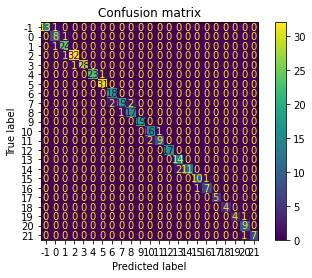

In [39]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [40]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,13,0.260889,0.510773,0.223589
1,chronological,Optuna,13,0.211634,0.460037,0.334537
3,random,normal,13,0.148111,0.384853,0.160495
4,random,Optuna,13,0.118242,0.343863,0.236382


In [41]:
from training.results import plot_summary

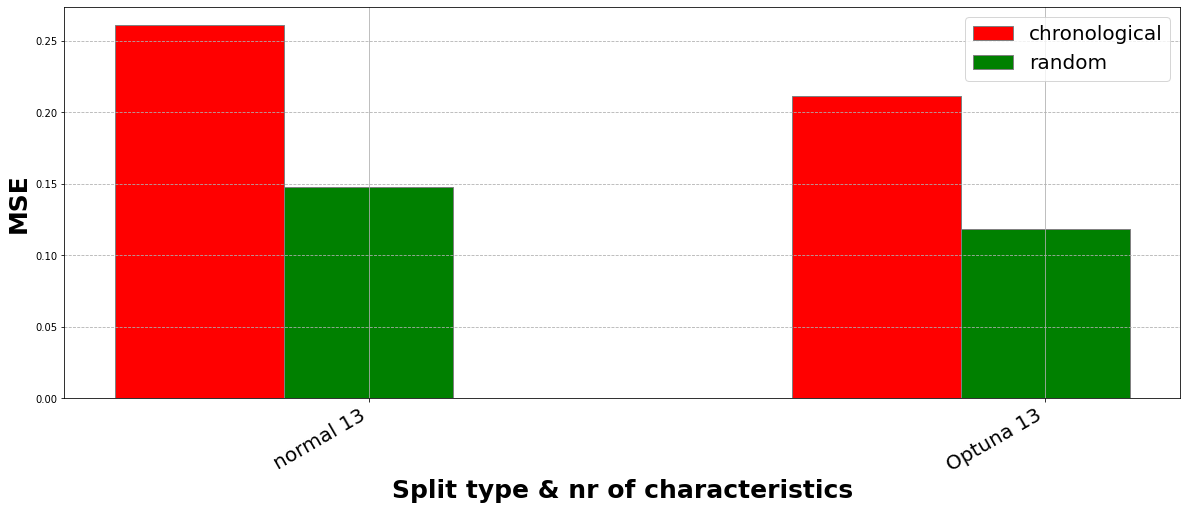

In [42]:
plot_summary(results, "MSE")

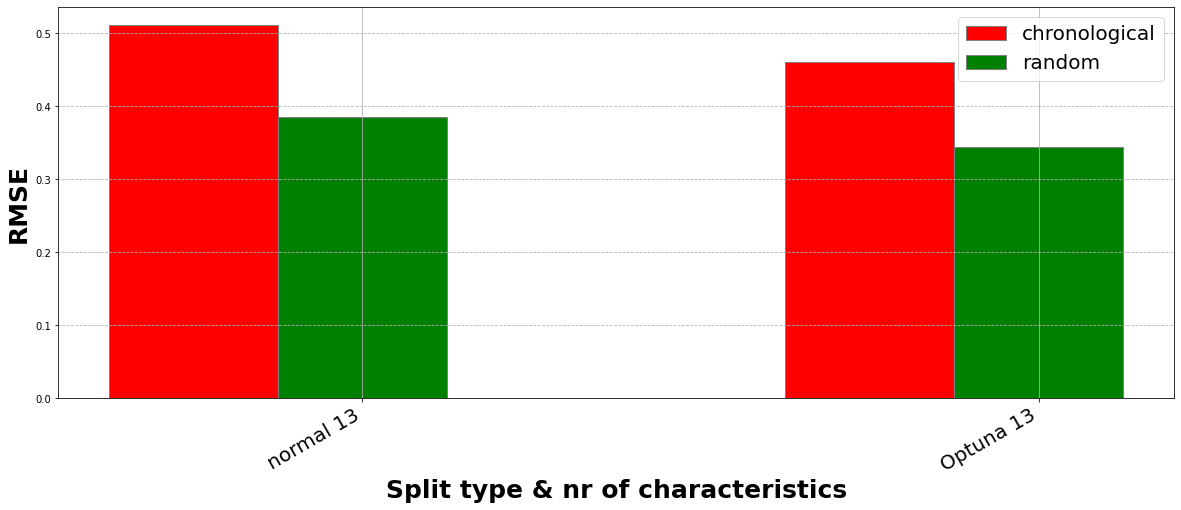

In [43]:
plot_summary(results, "RMSE")

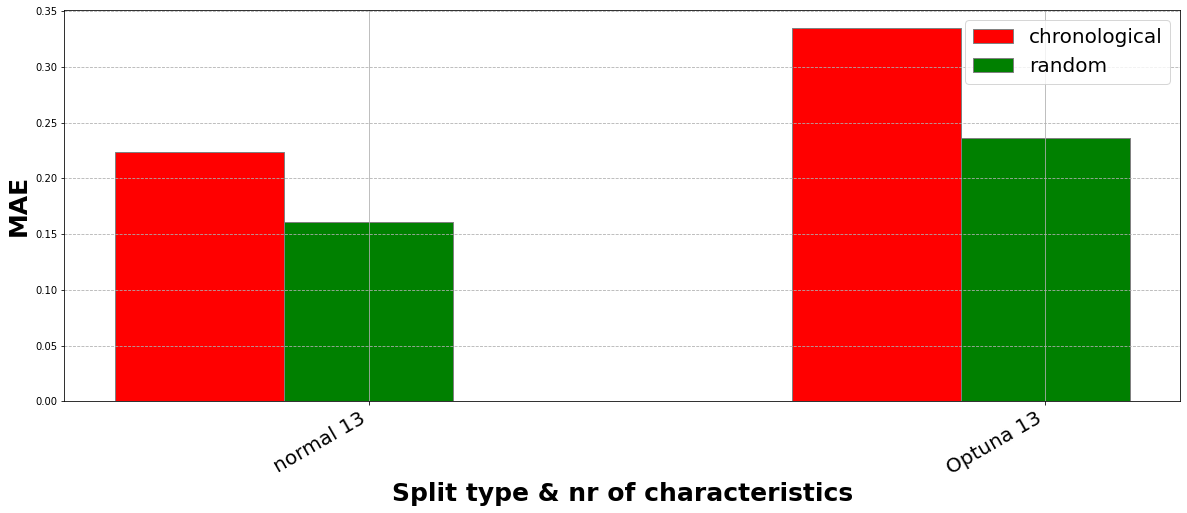

In [44]:
plot_summary(results, "MAE")

In [46]:
results.to_json("./lightgbm_second_results.json")